The first step is to include the necessary libraries: numpy and math for calculations, matplotlib to plot the results, random to generate random numbers and time to control the execution time required.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import math
import time

The first of the two functions below is the heart of the algorithm, it generates the neutrons, calculate their positions, and builds the histogram which is finally send back to the caller. The second function essentially plots the results. 
The neutron_transport function takes as input the L/D factor of the neutron source, the upper and lower dimensions, the collimator's height (the collimator's base is always placed at 0), its L and D, and the distance between the source and the collimator, and the distance between the collimator and the detector. 
Following up, each neutron is generated at a random position within the source line, with a random angle determined by the L/D of the source. With this information, the algorithm calculates the position in which the neutron enters and exits the collimator, as well as the position in which it will impact the detector (in case it can pass through the collimator). If both the entering and exiting position are within the same channel, and it is an air channel, the neutron is allowed to pass through, and its position is registered on the histogram. 

In [2]:
def randomangle_Cone(alpha):
    theta = math.pi/2 -np.arccos(random.random()*np.cos(math.pi/2-alpha/2))
    phi   = random.random()*2*math.pi
    A = np.sqrt(1+np.tan(phi)**2)
    if math.pi/2 < phi <= 3*math.pi/2:
        ZX = - np.arctan(np.tan(theta)/A)
        ZY = - np.arctan(np.tan(theta)*np.tan(phi)/A)
    else:
        ZX = np.arctan(np.tan(theta)/A)
        ZY = np.arctan(np.tan(theta)*np.tan(phi)/A)
    return(ZX,ZY,theta,phi)

def randomangle_Square(alpha):
    X = random.random() * alpha - (alpha / 2)
    Y = random.random() * alpha - (alpha / 2)
    return (X,Y)

def position_uniform(lower_generator,upper_generator):
    return (lower_generator + random.random()*(upper_generator-lower_generator),lower_generator + random.random()*(upper_generator-lower_generator))

def position_gaussian(lower_generator,upper_generator,upper_collimator_wide):
    neutron_position_X,neutron_position_Y = 10000,10000
    while(neutron_position_X > upper_generator or neutron_position_Y > upper_generator or neutron_position_X < lower_generator or neutron_position_Y < lower_generator):
        rng1 = random.random()
        rng2 = random.random()
        neutron_position_X = np.sqrt(-2*np.log(rng1))*np.cos(2*math.pi*rng2) * (upper_generator-lower_generator)/5 + upper_collimator_wide/2 
        neutron_position_Y = np.sqrt(-2*np.log(rng1))*np.sin(2*math.pi*rng2) * (upper_generator-lower_generator)/5 + upper_collimator_wide/2
    return (neutron_position_X,neutron_position_Y)

def neutron_transport(LD,upper_generator,lower_generator,number_of_channels,col_D, col_L, dist_to_col,dist_to_det,iterations):
    #histogram = []
    #histogram_white = []
    #X_distribution = []
    #Y_distribution = []
    '''
    data = {}
    data["histogram"] = []
    data["histogram_white"] = []
    data["X_distribution"] = []
    data["Y_distribution"] = []
    data["X_distribution_white"] = []
    data["Y_distribution_white"] = []
    '''
    file_positions = open("Pavia0/Testrun-of-full-sim-positionXY.txt","a")
    file_AnglesX = open("Pavia0/Testrun-of-full-sim-AngleX.txt","a")
    file_AnglesY = open("Pavia0/Testrun-of-full-sim-AngleY.txt","a")
    
    alpha = 2*np.arctan(1/LD)
    print(alpha)
    upper_collimator = col_D * ((number_of_channels * 2))
    upper_collimator_wide = col_D * ((number_of_channels * 2) + 1)
    #if upper_collimator > upper_generator:
    #    upper_generator = upper_collimator - lower_generator
    #print(LD,upper_generator,lower_generator,upper_collimator,col_D,col_L)
    
    for i in range(iterations):
        #if i/iterations*100 % 10 == 0: 
        #    print(100*(i/iterations),"%")
        
        #Define the position and angle of the neutron generated in 2D
        neutron_position_X,neutron_position_Y = position_uniform(lower_generator,upper_generator)
        #neutron_position_X,neutron_position_Y = position_gaussian(lower_generator,upper_generator,upper_collimator_wide)
        
        #neutron_angle_X,neutron_angle_Y = randomangle_Square(alpha)
        neutron_angle_X,neutron_angle_Y,theta,phi = randomangle_Cone(alpha)
        
        LD_neutron_X = np.tan(neutron_angle_X/2)
        LD_neutron_Y = np.tan(neutron_angle_Y/2)
        
        #Calculate entering an exiting positions in the collimator
        hli_X = dist_to_col * LD_neutron_X + neutron_position_X
        hlf_X = (dist_to_col + col_L) * LD_neutron_X + neutron_position_X
        hli_Y = dist_to_col * LD_neutron_Y + neutron_position_Y
        hlf_Y = (dist_to_col + col_L) * LD_neutron_Y + neutron_position_Y
        hlmid_X,hlmid_Y = 0,0
        bordercase_X,bordercase_Y = False,False
        
        
        if hli_X < upper_collimator_wide < hlf_X and col_D < hli_Y < upper_collimator:
            hlmid_X = upper_collimator
            bordercase_X = True
        elif hli_X < 0 < hlf_X and col_D < hli_Y < upper_collimator:
            hlmid_X = 0
            bordercase_X = True
        elif hlf_X < upper_collimator_wide < hli_X and col_D < hli_Y < upper_collimator:
            hlmid_X = upper_collimator
            bordercase_X = True
        elif hlf_X < 0 < hli_X and col_D < hli_Y < upper_collimator:
            hlmid_X = 0
            bordercase_X = True
        
        if hli_Y < upper_collimator_wide < hlf_Y and col_D < hli_X < upper_collimator:
            hlmid_Y = upper_collimator
            bordercase_Y = True
        elif hli_Y < 0 < hlf_Y and col_D < hli_X < upper_collimator:
            hlmid_Y = 0
            bordercase_Y = True
        elif hlf_Y < upper_collimator_wide < hli_Y and col_D < hli_X < upper_collimator:
            hlmid_Y = upper_collimator
            bordercase_Y = True
        elif hlf_Y < 0 < hli_Y and col_D < hli_X < upper_collimator:
            hlmid_Y = 0
            bordercase_Y = True
            
        #if 10 < neutron_position_X < 30 and 10 < neutron_position_Y < 30:
            #data["histogram_white"].append([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])                    
            #data["X_distribution_white"].append(neutron_angle_X)
            #data["Y_distribution_white"].append(neutron_angle_Y)
        #print("border X: ",bordercase_X," border Y: ",bordercase_Y)
        #Start the magic: general case: if the neutron is inside the collimator's area, and the start and end cell
        #are the same, the neutron is evaluated.
        if (0 <= hli_X <= upper_collimator_wide) and (0 <= hli_Y <= upper_collimator_wide) and (bordercase_X == False) and (bordercase_Y == False):
            if (math.floor(hli_X/col_D) % 2) != 0:
                if (math.floor(hli_Y/col_D) % 2) == 0:
                    if math.floor(hlf_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hli_Y/col_D):
                        file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")
                        file_AnglesX.write(str(neutron_angle_X)+",")
                        file_AnglesY.write(str(neutron_angle_Y)+",")
            else:
                if (math.floor(hli_Y/col_D) % 2) != 0: 
                    if math.floor(hlf_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hli_Y/col_D):
                        file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")                    
                        file_AnglesX.write(str(neutron_angle_X)+",")
                        file_AnglesY.write(str(neutron_angle_Y)+",")
            #This elif determines the case in which the neutron enters either the left or right border
            #there are 2 casualities: either enters within and exits in the middle, or enters in the middle and exits properly
        elif bordercase_X == True:
            if 0 < hli_X < upper_collimator_wide:
                #print("Border X from inside")
                if (math.floor(hli_X/col_D) % 2) != 0:
                    if (math.floor(hli_Y/col_D) % 2) == 0:
                        if math.floor(hlmid_X/col_D) == math.floor(hlmid_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hli_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                else:
                    if (math.floor(hli_Y/col_D) % 2) != 0: 
                        if math.floor(hlmid_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hli_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")                    
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
            else:
                #print("Border X from outside")
                if (math.floor(hlmid_X/col_D) % 2) != 0:
                    if (math.floor(hli_Y/col_D) % 2) == 0:
                        if math.floor(hlf_X/col_D) == math.floor(hlmid_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hli_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                else:
                    if (math.floor(hli_Y/col_D) % 2) != 0: 
                        if math.floor(hlf_X/col_D) == math.floor(hlmid_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hli_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")                    
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                
            #The same process is followed for upper and lower borders:
        elif bordercase_Y == True:
            if 0 < hli_Y < upper_collimator_wide:
                #print("Border Y from inside ","hli_X: ",hli_X,"hli_Y: ",hli_Y,"hlmid_Y: ",hlmid_Y,"hlf_Y: ",hlf_Y)
                if (math.floor(hli_X/col_D) % 2) != 0:
                    if (math.floor(hli_Y/col_D) % 2) == 0:
                        if math.floor(hlf_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlmid_Y/col_D) == math.floor(hli_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                else:
                    if (math.floor(hli_Y/col_D) % 2) != 0: 
                        if math.floor(hlf_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlmid_Y/col_D) == math.floor(hli_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")                    
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                
            else: 
                #print("Border Y from outside")
                if (math.floor(hli_X/col_D) % 2) != 0:
                    if (math.floor(hlmid_Y/col_D) % 2) == 0:
                        if math.floor(hlf_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hlmid_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                else:
                    if (math.floor(hlmid_Y/col_D) % 2) != 0: 
                        if math.floor(hlf_X/col_D) == math.floor(hli_X/col_D) and math.floor(hlf_Y/col_D) == math.floor(hlmid_Y/col_D):
                            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")                    
                            file_AnglesX.write(str(neutron_angle_X)+",")
                            file_AnglesY.write(str(neutron_angle_Y)+",")
                
            #of course, if the neutron is outside of the collimator, nothing can stop it (unlimited power!)
        else:
            file_positions.write(str([(dist_to_col+col_L+dist_to_det)*LD_neutron_X + neutron_position_X,(dist_to_col+col_L+dist_to_det)*LD_neutron_Y + neutron_position_Y])+",")
            file_AnglesX.write(str(neutron_angle_X)+",")
            file_AnglesY.write(str(neutron_angle_Y)+",")
    #print("Completed")
    file_positions.close()
    file_AnglesX.close()
    file_AnglesY.close()
    message = "Everything's fine"
    return message

#Plotting function
def plot3D(x,y,dist_to_det,condition):
    plt.figure(figsize=(14,12))
    
    plt.hist2d(x,y,bins=200,range=[[10,30],[10,30]])
    plt.xlabel("X coordinate (mm)")
    plt.ylabel("Y coordinate (mm)")
    plt.colorbar()
    title = "Neutron count with LD "+str(dist_to_det)
    plt.savefig(title)
    if condition == True:
        title1 = "Hist-Geometry3D-"+str(run)+".txt"
        title2 = "Xax-Geometry3D-"+str(run)+".txt"
        title3 = "Yax-Geometry3D-"+str(run)+".txt"
    elif condition == False: 
        title1 = "Hist_white-Geometry3D-"+str(run)+".txt"
        title2 = "Xax_white-Geometry3D-"+str(run)+".txt"
        title3 = "Yax_white-Geometry3D-"+str(run)+".txt"
    
    f1 = open(title1,"a")
    f2 = open(title2,"a")
    f3 = open(title3,"a")
    
    
    hist,xax,yax,image = plt.hist2d(x,y,bins=200,range=[[10,30],[10,30]])
    print("Hist dimensions pre: ",len(hist))
    for item in (hist):
        for elem in item:
            f1.write(str(elem))
            f1.write(",")
    f1.close()
    for item in (xax):
        f2.write(str(item))
        f2.write(",")
    f2.close()
    for item in (yax):
        f3.write(str(item))
        f3.write(",")
    f3.close()
    print("file(s) saved")

def readplot3d(run):
    
    title1 = "Hist-Geometry3D-"+str(run)+".txt"
    title2 = "Xax-Geometry3D-"+str(run)+".txt"
    title3 = "Yax-Geometry3D-"+str(run)+".txt"
    
    with open(title1, 'r') as file:
        hist = np.array(eval(file.read())) # read list string and convert to array
    with open(title2, 'r') as file:
        xax = np.array(eval(file.read())) # read list string and convert to array
    with open(title3, 'r') as file:
        yax = np.array(eval(file.read())) # read list string and convert to array
    return hist, xax, yax

def savedata (content,title,argument):
    label = ["positionXY","AngleX","AngleY","positionXY_white","AngleX_white","AngleY_white"]
    Fulltitle = title + label[argument] + ".txt"
    file = open(Fulltitle,"a")
    for elem in content:
        file.write(str(elem))
        file.write(",")
    

In [3]:
#LD of the initial beam
#LD = 27.2
LD = 30

#Monkey control
if LD == 0:
    LD = 5

#upper height of the generator
upper = 40

#lower height of the generator
lower = 0

#number of air channels
number_of_channels = 20

if number_of_channels <= 2:
    number_of_channels = 2

#diameter of each channel
col_D = 2.5

#length of each collimator channel
col_L = 400

#distance from beam start to collimator
dist_to_col = 5000 #Pavia
#dist_to_col = 1000 #ISIS

#distance from end of collimator to detector
dist_to_det = 10
'''
upper_collimator = col_D * ((number_of_channels * 2) + 1)
if upper_collimator > upper:
    upper = upper_collimator - lower
'''
#iterations = 50000000
iterations = 3000000

In [ ]:
for run in range(1):
    print("--> Starting run ",run,"<--")
    start_time = time.time()
    #histogram = neutron_transport(LD,upper,lower,number_of_channels,col_D, col_L, dist_to_col,dist_to_det,iterations)
    message = neutron_transport(LD,upper,lower,number_of_channels,col_D, col_L, dist_to_col,dist_to_det,iterations)
    print(message)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    with open("Pavia0/Testrun-of-full-sim-positionXY.txt", 'r') as file:
        position = np.array(eval(file.read())) # read list string and convert to array
    file.close()
    
    plot3D(position[:,0],position[:,1],run,True)
    '''
    X = []
    Y = []
    for ble in range(len(data["histogram_white"])):
        X.append(data["histogram_white"][ble][0])
        Y.append(data["histogram_white"][ble][1])
    plot3D(X,Y,run,False)
    '''
    print("--> Completed run ",run,"<--")
    print("\n","============================","\n")

--> Starting run  0 <--
0.06664199175649439
Everything's fine
--- 192.90054488182068 seconds ---


In [ ]:
with open("Test3/Testrun-of-full-sim-positionXY.txt", 'r') as file:
    position = np.array(eval(file.read())) # read list string and convert to array
file.close()
run = 0
plot3D(position[:,0],position[:,1],run,True)

In [ ]:
hist,xax,yax = readplot3d(0)
hist_resh = np.reshape(np.array(hist.tolist()).astype(np.float),[200,200])
print(hist_resh.shape)

In [ ]:
print(hist_resh[0:2,0:4])

plt.plot(hist_resh[100])
plt.figure(figsize=(40,11))
plt.show()

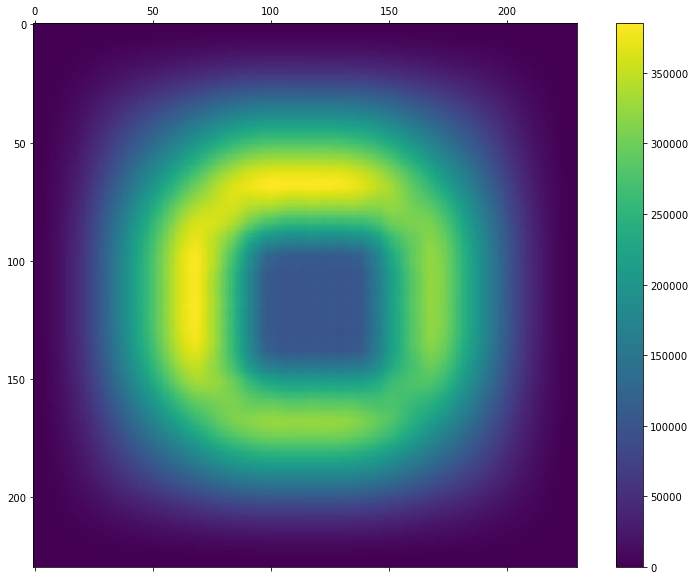

In [42]:
blank = np.zeros([230,230])
for i in range(30):
    for j in range(30):
        blank[j:j+200,i:i+200]+=hist_resh
fig = plt.figure(figsize=(14,10))
mat = fig.add_subplot(111)
tax = mat.matshow(blank)
#plt.imshow(tax)
fig.colorbar(tax)


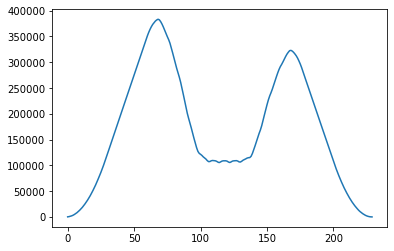

<Figure size 2880x792 with 0 Axes>

In [43]:
plt.plot(blank[100])
plt.figure(figsize=(40,11))
plt.show()

--> Starting run  0 <--
0.03571049027910503
25 -10 20.0 2.5 110
0.0 %
0.2 %
0.4 %
0.6 %
0.8 %
1.0 %
1.2 %
1.4 %
1.6 %
1.8 %
--- 263.1915156841278 seconds ---
Hist dimensions pre:  200
xax:  [-1.22213946e+01 -1.20242466e+01 -1.18270986e+01 -1.16299506e+01
 -1.14328027e+01 -1.12356547e+01 -1.10385067e+01 -1.08413587e+01
 -1.06442107e+01 -1.04470627e+01 -1.02499148e+01 -1.00527668e+01
 -9.85561880e+00 -9.65847082e+00 -9.46132284e+00 -9.26417485e+00
 -9.06702687e+00 -8.86987889e+00 -8.67273090e+00 -8.47558292e+00
 -8.27843494e+00 -8.08128696e+00 -7.88413897e+00 -7.68699099e+00
 -7.48984301e+00 -7.29269503e+00 -7.09554704e+00 -6.89839906e+00
 -6.70125108e+00 -6.50410310e+00 -6.30695511e+00 -6.10980713e+00
 -5.91265915e+00 -5.71551117e+00 -5.51836318e+00 -5.32121520e+00
 -5.12406722e+00 -4.92691924e+00 -4.72977125e+00 -4.53262327e+00
 -4.33547529e+00 -4.13832731e+00 -3.94117932e+00 -3.74403134e+00
 -3.54688336e+00 -3.34973537e+00 -3.15258739e+00 -2.95543941e+00
 -2.75829143e+00 -2.56114344e+

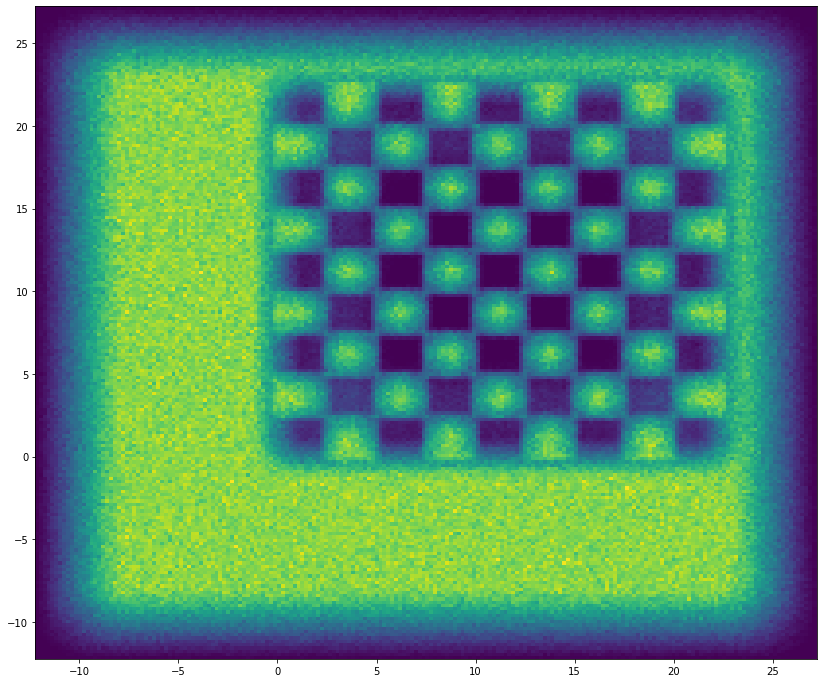

In [29]:
for run in range(1):
    print("--> Starting run ",run,"<--")
    start_time = time.time()
    histogram = neutron_transport(LD,upper,lower,number_of_channels,col_D, col_L, dist_to_col,dist_to_det,iterations)
    print("--- %s seconds ---" % (time.time() - start_time))
    X = []
    Y = []
    for bla in range(len(histogram)):
        X.append(histogram[bla][0])
        Y.append(histogram[bla][1])
    plot3D(X,Y,run)
    print("--> Completed run ",run,"<--")
    print("\n","============================","\n")

3442039


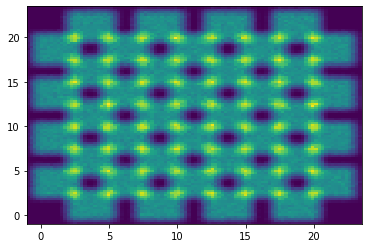

In [18]:
print(len(histogram))
X = []
Y = []
for bla in range(len(histogram)):
    X.append(histogram[bla][0])
    Y.append(histogram[bla][1])
plot3D(X,Y)

3441184


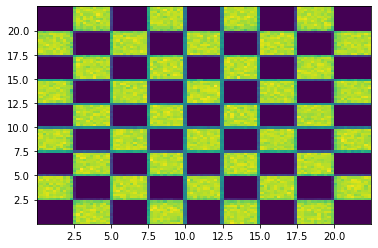

In [24]:
print(len(histogram))
X = []
Y = []
for bla in range(len(histogram)):
    X.append(histogram[bla][0])
    Y.append(histogram[bla][1])
plot3D(X,Y)

3441840


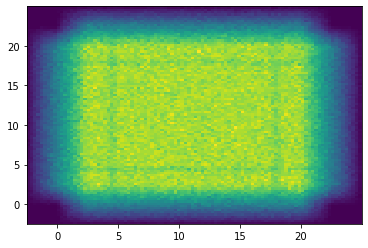

In [27]:
print(len(histogram))
X = []
Y = []
for bla in range(len(histogram)):
    X.append(histogram[bla][0])
    Y.append(histogram[bla][1])
plot3D(X,Y)

In [3]:
iter = 1
title = "Geometry3D-"+str(iter)+".txt"
content=[1,2,3,4,5]
f = open(title,"a")
for item in content:
    f.write(str(item))
    f.write("\n")
f.close()
print("completed")

completed


1175795


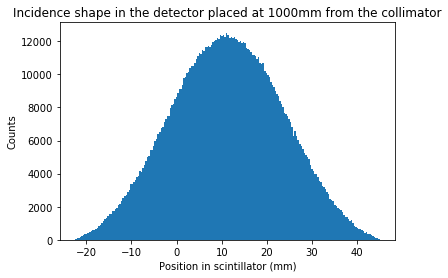

In [43]:
plot(histogram,200,dist_to_det)

1178672


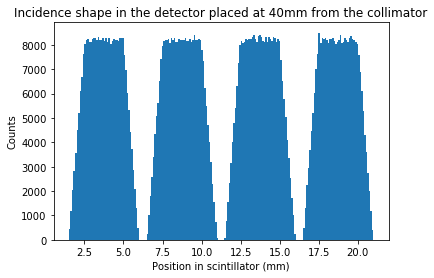

In [46]:
plot(histogram,200,dist_to_det)